In [1]:
import json
import time
import os

from pymongo import MongoClient

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

client = MongoClient("localhost", 27017)
db = client['usgs']

%matplotlib inline

In [296]:
def align_measurements(t_meas, y_meas, t_corr, y_corr):
    dt_corr, n_corr = np.unique(t_corr[1:] - t_corr[:-1], return_counts=True)
    dt_meas, n_meas = np.unique(t_meas[1:] - t_meas[:-1], return_counts=True)
    dt = min(dt_corr[np.argmax(n_corr)], dt_meas[np.argmax(n_meas)])
    
    offset_corr = max(t_corr[0] - t_meas[0], 0)
    offset_meas = max(t_meas[0] - t_corr[0], 0)
    N = (max(t_corr[-1], t_meas[-1]) - min(t_corr[0], t_meas[0])) // dt + 1
    
    y_corr_new = np.zeros(N) - 1
    y_meas_new = np.zeros(N) - 1
    
    idx_corr = np.cumsum((t_corr[1:] - t_corr[:-1]) // dt) + offset_corr // dt
    idx_meas = np.cumsum((t_meas[1:] - t_meas[:-1]) // dt) + offset_meas // dt
    
    y_corr_new[idx_corr] = y_corr[1:]
    y_meas_new[idx_meas] = y_meas[1:]
    
    y_corr_new[0] = y_corr[0]
    y_meas_new[0] = y_meas[0]
    
    return y_meas_new, y_corr_new


def mark_anomaly(y_m, y_c, anomaly_thresh):
    return np.logical_or(y_c < 0, np.abs(y_c - y_m) > anomaly_thresh)   

In [230]:
to_shift = {
    14137000 : -687,
    7377500  : +2,
    8186500  : +2,
    11456000 : +2
}

In [3]:
sites = db['cites']
measured = db['measured']
corrected = db['corrected']

cursor = sites.find()
sid = [c['site_no'] for c in cursor]

3144000


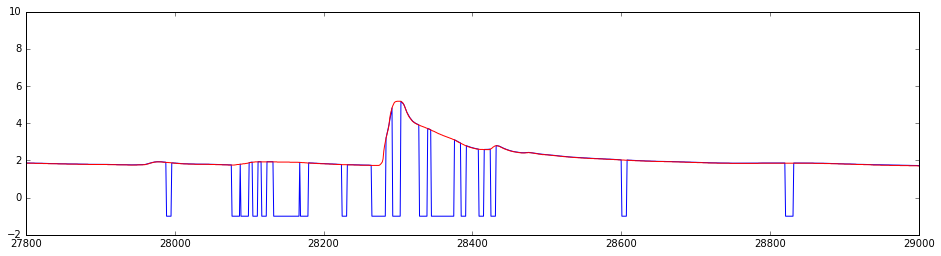

In [384]:
si = 3144000 # sorted(impurity)[-67]

def get_data(db, site_id):
    data_m = db['measured'].find_one({'site_no': site_id})
    data_c = db['corrected'].find_one({'site_no': site_id})
    
    if data_m is None or data_c is None:
        raise Exception("Site not found")
        
    Tm = np.array(data_m['utc'], dtype=np.int32)
    Zm = np.array(data_m['gh'],  dtype=np.float32)
    
    Tc = np.array(data_c['utc'], dtype=np.int32)
    Zc = np.array(data_c['gh'],  dtype=np.float32)
    
    if site_id in to_shift:
        Zm += to_shift[site_id]
        Zc += to_shift[site_id]
    
    #Ym, Yc = align_measurements(Tm, Zm, Tc, Zc)
    
    return Tm, Zm, Tc, Zc
        
    
def fix_sampling_rate(y, d, interpolation='const'):
    z = y.copy()
    k = 0
    flag = False
    for i in range(1, z.size):        
        if z[i] <= 0 and z[i-1] > 0:
            flag = True  
        if z[i] > 0 and z[i-1] > 0:
            flag = False
        if z[i] <= 0 and z[i-1] <= 0 and flag:
            k += 1            
        if z[i] > 0 and z[i-1] <= 0 and flag:
            if k <= d-1:
                if interpolation == 'const':
                    z[i-k-1:i] = z[i-k-2]
                elif interpolation == 'linear':
                    z[i-k-1:i] = z[i-k-2] + (z[i] - z[i-k-2])*np.linspace(0,1,k+3)[1:-1]
            else:
                flag = False
            k = 0
    return z


Tm, Zm, Tc, Zc = get_data(db, si)

abs_thresh = np.median(Zm) + 15*np.subtract(*np.percentile(Zm, [90, 10]))
Zm[Zm <= 0] = -1
Zm[Zm > abs_thresh] = -1

Ym, Yc = align_measurements(Tm, Zm, Tc, Zc)  

Ym = fix_sampling_rate(Ym, 4, interpolation = 'linear')
Yc = fix_sampling_rate(Yc, 4, interpolation = 'linear')

plt.figure(figsize = (16,4))
plt.plot(Ym, 'b-')
plt.plot(Yc, 'r-')
#plt.ylim(1,3)
plt.xlim(27800,29000)

print(si)

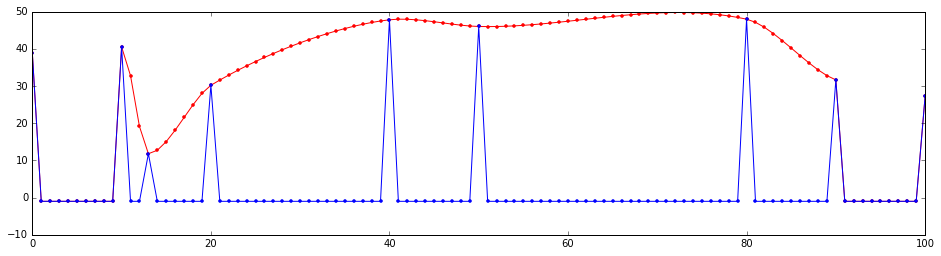

In [729]:
def bezier_interpolator(x_a, y_a, dy_a, x_b, y_b, dy_b, x):
    if False: # x.size < 4:
        By = 0.5*(y_a + y_b) * np.ones(x.size)
    
    else:
        # cubic bezier curve
        x_1 = x[x.size // 3]  
        x_2 = x[x.size - x.size // 3] 
        y_1 = y_a + dy_a*(x_1 - x_a)        
        y_2 = y_b + dy_b*(x_2 - x_b)        
        t = np.zeros(x.size)
        for i in range(x.size):
            r = np.roots([x_b - 3*x_2 + 3*x_1 - 1*x_a,
                                3*x_2 - 6*x_1 - 3*x_a,
                                        3*x_1 - 3*x_a,
                                                1*x_a - x[i]])
            idx = np.where(np.logical_and(r <= 1, r >= 0))[0][0]
            t[i] = r[idx]
        By = (1-t)**3 * y_a + 3*t*(1-t)**2 * y_1 + 3*(1-t)*t**2 * y_2 + t**3 * y_b
        
    return By


def get_bisector(x, y, xl, yl, xr, yr):
    x1 = x - xl
    y1 = y - yl
    x1_n = np.sqrt(x1**2 + y1**2)

    x2 = xr - x
    y2 = yr - y
    x2_n = np.sqrt(x2**2 + y2**2)
    
    y3 = (y1 / x1_n + y2 / x2_n) / (x1 / x1_n + x2 / x2_n)
    return 1, y3


x = np.zeros(101) - 1
x[::10] = 30 + 10*np.random.randn(11)
x[13] = 30 + 10*np.random.randn()
x[30] = -1
x[60] = -1
x[70] = -1


def fix_sampling_rate(y, d, interpolation='const'):
    z = y.copy()
    k = 0
    flag = False
    for i in range(1, z.size):        
        if z[i] <= 0 and z[i-1] > 0:
            flag = True  
        if z[i] > 0 and z[i-1] > 0:
            flag = False
        if z[i] <= 0 and z[i-1] <= 0 and flag:
            k += 1            
        if z[i] > 0 and z[i-1] <= 0 and flag:
            if k <= d-1:
                if interpolation == 'const':
                    z[i-k-1:i] = z[i-k-2]
                elif interpolation == 'linear':
                    z[i-k-1:i] = z[i-k-2] + (z[i] - z[i-k-2])*np.linspace(0,1,k+3)[1:-1]
            else:
                flag = False
            k = 0
    return z

a = 0
b = 0
c = 0
d = 0

z = x.copy()
k = 0
flag = False
for i in range(1, z.size):        
    if z[i] <= 0 and z[i-1] > 0:
        flag = True  
    if z[i] > 0 and z[i-1] > 0:
        a = b
        b = c
        c = d
        d = i
        flag = False
    if z[i] <= 0 and z[i-1] <= 0 and flag:
        k += 1            
    if z[i] > 0 and z[i-1] <= 0 and flag:
        a = b
        b = c
        c = d
        d = i        
        k = 0
    if b != 0 and c - b > 1:
        _, dy_b = get_bisector(b, x[b], a, x[a], c, x[c])
        _, dy_c = get_bisector(c, x[c], b, x[b], d, x[d])
        z[b:c] = bezier_interpolator(0, x[b], dy_b, c-b, x[c], dy_c, np.arange(c-b))


plt.figure(figsize = (16,4))
plt.plot(z, 'r.-')

#_, dy_b = get_bisector(b, x[b], a, x[a], c, x[c])
#_, dy_c = get_bisector(c, x[c], b, x[b], d, x[d])

#t = np.linspace(b,c-1,20)
#z = bezier_interpolator(0, x[b], dy_b, c-b, x[c], dy_c, np.arange(20))
#plt.plot(t, z, 'g.-')
    
#t = np.linspace(a,c,200)
#z = x[b] + dy_b * (t - b)
#plt.plot(t, z, 'r-')

#t = np.linspace(b,d,200)
#z = x[c] + dy_c * (t - c)
#plt.plot(t, z, 'r-')


plt.plot(x, 'b.-')

In [ ]:
k = 256
step = k // 2
m = k // 2 + 1
n = y_m.size // step + 1
spectrogram = np.zeros((m, n))

for i in range(0, y_m.size - 2*step, step):
    amp = np.abs(np.fft.rfft(y_m[i:i+k]))
    spectrogram[:,i // step] = amp

plt.figure(figsize=(16,4))
plt.imshow(np.log(1 + np.flipud(spectrogram)), aspect='auto')

In [ ]:
plt.figure(figsize = (16,4))
plt.plot(y_m)
plt.xlim(0, y_m.size)

In [ ]:
abs_thresh = 200

y_m[np.where(y_m <= 0)[0]] = -1
y_m[np.where(y_m > abs_thresh)[0]] = -1

dy = np.hstack([y_m[1:] - y_m[:-1], 0])
ddy = np.hstack([0, dy[1:] - dy[:-1]])

# max_dy = np.zeros(dy.size)
# k = 10
# for j in range(k, dy.size):
#     max_dy[j] = np.max(np.abs(dy[j-k:j]))

plt.figure(figsize = (16,6))

plt.title('Site ID %i' % sid[si])
plt.plot(y_m, 'b-')
plt.plot(y_c, 'r-')

z = np.convolve(y_m, [-1,2,-1], mode='same')

#plt.plot(np.arange(y_c.size)[is_outlier], y_c[is_outlier], 'r.')
#plt.plot(z, 'r-')
# plt.plot()
plt.legend(['Measured', 'Fixed'])

plt.grid()
plt.ylim(2.5,3.5)
#plt.xlim(10000,20000)

In [ ]:
e = y_c - y_m
plt.hist(e[np.abs(e) < 1]);